# Step 2: Homology Search

## 🎯 Overview

This notebook demonstrates the homology search process for finding template protein structures. We use HHblits to search PDB70 and UniRef30 databases to find homologous sequences with known 3D structures that can guide contact prediction.

## 📋 Learning Objectives

- Understand homology-based template discovery
- Configure and run HHblits database searches
- Process and validate template search results
- Analyze template quality and coverage

## 🔬 Key Concepts

**Homology Search**: Finding evolutionary related sequences to leverage structural conservation.

**PDB70 Database**: Non-redundant set of protein structures at 70% sequence identity.

**UniRef30 Database**: Clustered protein sequences at 30% identity for distant homologs.

**Template Quality**: Assessed by sequence identity, coverage, and alignment score.

---

## 🛠️ Setup and Dependencies

In [1]:
# Import required libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import subprocess
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import project modules
from src.esm2_contact.homology.search import (
    TemplateSearcher, DatabaseConfig, TemplateSearchResult, DualSearchResult
)

print("✅ Dependencies imported successfully")
print(f"📁 Project root: {project_root}")
print(f"🐍 Python version: {sys.version.split()[0]}")

✅ Dependencies imported successfully
📁 Project root: /home/calmscout/Projects/PythonProjects/esm2-contact-prediction
🐍 Python version: 3.13.2


## 🔧 Database Configuration Check

In [2]:
def check_database_configuration():
    """
    Check the status of HHblits databases required for homology search.
    """
    print("🗄️ Database Configuration Check")
    print("="*40)
    
    # Initialize database configuration
    db_config = DatabaseConfig()
    
    print(f"\n📂 Database directory: {db_config.base_dir}")
    print(f"\n📊 Available databases:")
    
    for db_type, db_info in db_config.databases.items():
        status_icon = "✅" if db_info['status'] == 'ready' else "⚠️"
        print(f"   {status_icon} {db_type.upper()}: {db_info['status']}")
        print(f"      Description: {db_info['description']}")
        print(f"      Path: {db_info['path']}")
        
        if db_info['status'] == 'ready':
            # Check database files
            db_path = Path(db_info['path'])
            if db_path.exists():
                files = list(db_path.glob('*'))
                print(f"      Files: {len(files)} database files")
        print()
    
    # Check HHblits installation
    print("🔍 Checking HHblits installation...")
    try:
        result = subprocess.run(['hhblits', '-h'], 
                              capture_output=True, text=True, timeout=10)
        if result.returncode == 0:
            print("   ✅ HHblits is installed and accessible")
            
            # Get version info
            version_lines = [line for line in result.stdout.split('\n') 
                           if 'version' in line.lower() or 'hhblits' in line.lower()]
            if version_lines:
                print(f"   📋 Version info: {version_lines[0].strip()}")
        else:
            print("   ❌ HHblits not accessible")
    except (subprocess.TimeoutExpired, FileNotFoundError):
        print("   ❌ HHblits not found")
    
    return db_config

# Check database configuration
db_config = check_database_configuration()

🗄️ Database Configuration Check

📂 Database directory: /home/calmscout/hhdbs

📊 Available databases:
   ✅ PDB70: ready
      Description: PDB70 structural templates (70% identity clustering)
      Path: /home/calmscout/hhdbs/pdb70
      Files: 10 database files

   ✅ UNIREF30: ready
      Description: UniRef30 sequence homologs (30% identity clustering)
      Path: /home/calmscout/hhdbs/UniRef30_2023_02_hhsuite
      Files: 9 database files

🔍 Checking HHblits installation...
   ✅ HHblits is installed and accessible
   📋 Version info: HHblits 3.3.0:


## 📊 Load Query Sequences

In [3]:
def load_query_sequences():
    """
    Load protein sequences that need template search.
    """
    print("📂 Loading Query Sequences")
    print("="*30)
    
    data_dir = project_root / "data" / "tiny_10"
    sequences_file = data_dir / "sequences.json"
    
    if not sequences_file.exists():
        print(f"❌ Sequences file not found: {sequences_file}")
        print("   Please run ground truth generation first.")
        return {}
    
    with open(sequences_file, 'r') as f:
        sequences = json.load(f)
    
    print(f"📊 Loaded {len(sequences)} sequences")
    
    # Display sequence information
    lengths = [len(seq) for seq in sequences.values()]
    print(f"   Length range: {min(lengths)} - {max(lengths)} residues")
    print(f"   Average length: {np.mean(lengths):.1f} residues")
    
    # Show first few sequences
    print(f"\n📋 Sample sequences:")
    for i, (protein_id, sequence) in enumerate(list(sequences.items())[:3]):
        print(f"   {protein_id}: {len(sequence)} residues")
        print(f"   {sequence[:60]}...")
        print()
    
    return sequences

# Load sequences
sequences = load_query_sequences()

📂 Loading Query Sequences
📊 Loaded 10 sequences
   Length range: 130 - 164 residues
   Average length: 154.2 residues

📋 Sample sequences:
   133L_A: 130 residues
   KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQIN...

   134L_A: 130 residues
   KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQIN...

   106M_A: 154 residues
   MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASE...



## 🔍 Template Search Demonstration

In [4]:
def demonstrate_template_search():
    """
    Demonstrate template search on a sample sequence.
    """
    if not sequences:
        print("❌ No sequences available for demonstration")
        return None
    
    print("🔍 Template Search Demonstration")
    print("="*40)
    
    # Select a sample sequence
    sample_protein_id = list(sequences.keys())[0]
    sample_sequence = sequences[sample_protein_id]
    
    print(f"🧬 Sample protein: {sample_protein_id}")
    print(f"   Sequence length: {len(sample_sequence)} residues")
    print(f"   Sequence: {sample_sequence[:50]}...")
    
    # Initialize template searcher
    cache_dir = project_root / "data" / ".template_cache"
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    searcher = TemplateSearcher(
        method="dual",  # Search both PDB70 and UniRef30
        min_identity=0.3,  # 30% minimum identity
        min_coverage=0.5,  # 50% minimum coverage
        max_templates=10,  # Maximum templates per query
        cache_dir=cache_dir,
        database_dir="/home/calmscout/hhdbs"
    )
    
    print(f"\n⚙️ Search configuration:")
    print(f"   Method: {searcher.method}")
    print(f"   Min identity: {searcher.min_identity}")
    print(f"   Min coverage: {searcher.min_coverage}")
    print(f"   Max templates: {searcher.max_templates}")
    print(f"   Cache directory: {searcher.cache_dir}")
    
    # Check if databases are ready
    pdb70_ready = searcher.db_config.is_ready('pdb70')
    uniref30_ready = searcher.db_config.is_ready('uniref30')
    
    print(f"\n📊 Database readiness:")
    print(f"   PDB70: {'✅' if pdb70_ready else '❌'}")
    print(f"   UniRef30: {'✅' if uniref30_ready else '❌'}")
    
    if not (pdb70_ready or uniref30_ready):
        print("\n❌ No databases are ready for searching")
        return None
    
    return searcher, sample_protein_id, sample_sequence

# Demonstrate template search setup
search_setup = demonstrate_template_search()

🔍 Template Search Demonstration
🧬 Sample protein: 133L_A
   Sequence length: 130 residues
   Sequence: KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDR...

⚙️ Search configuration:
   Method: dual
   Min identity: 0.3
   Min coverage: 0.5
   Max templates: 10
   Cache directory: /home/calmscout/Projects/PythonProjects/esm2-contact-prediction/data/.template_cache

📊 Database readiness:
   PDB70: ✅
   UniRef30: ✅


## 🚀 Running Template Search

In [10]:
def run_single_template_search():
    """
    Run template search on a single sequence to demonstrate the process.
    """
    if not search_setup:
        print("❌ Template search setup failed")
        return None
    
    searcher, protein_id, sequence = search_setup
    
    print(f"🚀 Running Template Search for {protein_id}")
    print("="*50)
    
    try:
        # Perform dual database search
        print("\n🔍 Searching databases...")
        results = searcher.search_dual_databases(sequence, protein_id)
        
        # Get search summary
        summary = results.get_summary()
        print(f"\n📊 Search Results:")
        print(f"   Structural templates: {summary['structural_templates']}")
        print(f"   Sequence homologs: {summary['sequence_homologs']}")
        print(f"   Total results: {summary['total_results']}")
        print(f"   PDB templates available: {summary['pdb_available']}")
        print(f"   Processing templates: {summary['processing_templates']}")
        
        # Analyze template quality
        if summary['structural_templates'] > 0:
            print(f"\n🏆 Top Structural Templates:")
            structural_templates = results.structural_templates[:5]
            
            for i, template in enumerate(structural_templates, 1):
                print(f"   {i}. {template.pdb_id}_{template.chain_id}")
                print(f"      Identity: {template.sequence_identity:.3f}")
                print(f"      Coverage: {template.coverage:.3f}")
                print(f"      E-value: {template.e_value:.2e}")
                print(f"      Score: {template.alignment_score:.1f}")
                print()
        
        if summary['sequence_homologs'] > 0:
            print(f"🔬 Top Sequence Homologs:")
            sequence_homologs = results.sequence_homologs[:3]
            
            for i, homolog in enumerate(sequence_homologs, 1):
                print(f"   {i}. {homolog.pdb_id}")
                print(f"      Identity: {homolog.sequence_identity:.3f}")
                print(f"      Coverage: {homolog.coverage:.3f}")
                print(f"      E-value: {homolog.e_value:.2e}")
                print()
        
        return results
        
    except Exception as e:
        print(f"❌ Template search failed: {e}")
        return None

# Uncomment to run single template search
search_results = run_single_template_search()
if search_results:
    print("✅ Template search completed successfully!")

# print("📝 Template search function ready.")
# print("💡 Uncomment the function call above to run the search.")
# print("⚠️  Note: This may take several minutes per protein.")

INFO:src.esm2_contact.homology.search:Performing dual database search for 133L_A
INFO:src.esm2_contact.homology.search:Searching PDB70 database for structural templates...
INFO:src.esm2_contact.homology.search:Running HHblits against pdb70 database


🚀 Running Template Search for 133L_A

🔍 Searching databases...


INFO:src.esm2_contact.homology.search:Extracted sequences for 86 templates
INFO:src.esm2_contact.homology.search:Found 86 template sequences for matching
INFO:src.esm2_contact.homology.search:Successfully parsed 49 hits from HHblits output using enhanced parser
INFO:src.esm2_contact.homology.search:PDB70 search completed: 49 templates found
INFO:src.esm2_contact.homology.search:Searching UniRef30 database for sequence homologs...
INFO:src.esm2_contact.homology.search:Running HHblits against uniref30 database
INFO:src.esm2_contact.homology.search:Extracted sequences for 41 templates
INFO:src.esm2_contact.homology.search:Found 41 template sequences for matching
INFO:src.esm2_contact.homology.search:Successfully parsed 492 hits from HHblits output using enhanced parser
INFO:src.esm2_contact.homology.search:UniRef30 search completed: 492 homologs found
INFO:src.esm2_contact.homology.search:Dual search completed: 49 templates, 492 homologs



📊 Search Results:
   Structural templates: 49
   Sequence homologs: 492
   Total results: 541
   PDB templates available: True
   Processing templates: 49

🏆 Top Structural Templates:
   1. 1bb7_A
      Identity: 1.000
      Coverage: 0.992
      E-value: 4.90e-42
      Score: 233.3

   2. 1lmn_A
      Identity: 1.000
      Coverage: 0.992
      E-value: 4.90e-42
      Score: 233.3

   3. 1lmq_A
      Identity: 1.000
      Coverage: 0.992
      E-value: 5.50e-42
      Score: 233.1

   4. 5xuw_A
      Identity: 1.000
      Coverage: 0.985
      E-value: 2.40e-41
      Score: 229.8

   5. 6t6c_A
      Identity: 1.000
      Coverage: 0.969
      E-value: 7.20e-41
      Score: 227.2

🔬 Top Sequence Homologs:
   1. unir
      Identity: 1.000
      Coverage: 1.000
      E-value: 3.10e-54

   2. unir
      Identity: 1.000
      Coverage: 0.992
      E-value: 1.20e-53

   3. unir
      Identity: 1.000
      Coverage: 0.992
      E-value: 4.60e-53

✅ Template search completed successfully!


## 📊 Analyze Existing Homology Results

In [6]:
def analyze_existing_homology_results():
    """
    Analyze existing homology search results from the pipeline.
    """
    data_dir = project_root / "data" / "tiny_10"
    homology_file = data_dir / "homology_results.json"
    
    if not homology_file.exists():
        print("❌ No existing homology results found")
        print("   Run the homology search script first:")
        print("   uv run python scripts/run_10_homology.py")
        return None
    
    print("📊 Analyzing Existing Homology Results")
    print("="*45)
    
    with open(homology_file, 'r') as f:
        results = json.load(f)
    
    # Extract metadata
    metadata = results.get('metadata', {})
    query_results = results.get('results', {})
    
    print(f"\n📋 Search Metadata:")
    print(f"   Total queries: {metadata.get('total_queries', 'Unknown')}")
    print(f"   Search method: {metadata.get('search_method', 'Unknown')}")
    print(f"   Timestamp: {metadata.get('timestamp', 'Unknown')}")
    
    # Analyze template statistics
    template_counts = []
    identity_scores = []
    coverage_scores = []
    successful_queries = 0
    
    print(f"\n🔍 Template Analysis:")
    
    for query_id, query_result in query_results.items():
        templates = query_result.get('templates', [])
        template_count = len(templates)
        
        if template_count > 0:
            successful_queries += 1
            template_counts.append(template_count)
            
            # Get best template statistics
            best_template = templates[0]
            identity_scores.append(best_template.get('sequence_identity', 0))
            coverage_scores.append(best_template.get('coverage', 0))
            
            print(f"   ✅ {query_id}: {template_count} templates")
            print(f"      Best: {best_template.get('template_pdb', 'Unknown')} "
                  f"(id={best_template.get('sequence_identity', 0):.3f}, "
                  f"cov={best_template.get('coverage', 0):.3f})")
        else:
            print(f"   ❌ {query_id}: No templates found")
    
    # Summary statistics
    total_queries = len(query_results)
    success_rate = successful_queries / total_queries if total_queries > 0 else 0
    
    print(f"\n📈 Summary Statistics:")
    print(f"   Total queries: {total_queries}")
    print(f"   Successful queries: {successful_queries}")
    print(f"   Success rate: {success_rate*100:.1f}%")
    
    if template_counts:
        print(f"   Templates per query: {np.mean(template_counts):.1f} ± {np.std(template_counts):.1f}")
        print(f"   Template range: {min(template_counts)} - {max(template_counts)}")
    
    if identity_scores:
        print(f"   Best identity: {np.mean(identity_scores):.3f} ± {np.std(identity_scores):.3f}")
        print(f"   Identity range: {min(identity_scores):.3f} - {max(identity_scores):.3f}")
    
    if coverage_scores:
        print(f"   Best coverage: {np.mean(coverage_scores):.3f} ± {np.std(coverage_scores):.3f}")
        print(f"   Coverage range: {min(coverage_scores):.3f} - {max(coverage_scores):.3f}")
    
    return results

# Analyze existing results
homology_results = analyze_existing_homology_results()

📊 Analyzing Existing Homology Results

📋 Search Metadata:
   Total queries: Unknown
   Search method: Unknown
   Timestamp: Unknown

🔍 Template Analysis:
   ✅ 133L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)
   ✅ 134L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)
   ✅ 106M_A: 10 templates
      Best: 2g10 (id=0.999, cov=0.000)
   ✅ 111M_A: 10 templates
      Best: 2g10 (id=0.999, cov=0.000)
   ✅ 109L_A: 10 templates
      Best: unir (id=0.999, cov=0.000)
   ✅ 115L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)
   ✅ 122L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)
   ✅ 138L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)
   ✅ 146L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)
   ✅ 150L_A: 10 templates
      Best: unir (id=1.000, cov=0.000)

📈 Summary Statistics:
   Total queries: 10
   Successful queries: 10
   Success rate: 100.0%
   Templates per query: 10.0 ± 0.0
   Template range: 10 - 10
   Best identity: 1.000 ± 0.000
   Ident

## 📈 Template Quality Visualization

📊 Template Quality Visualization


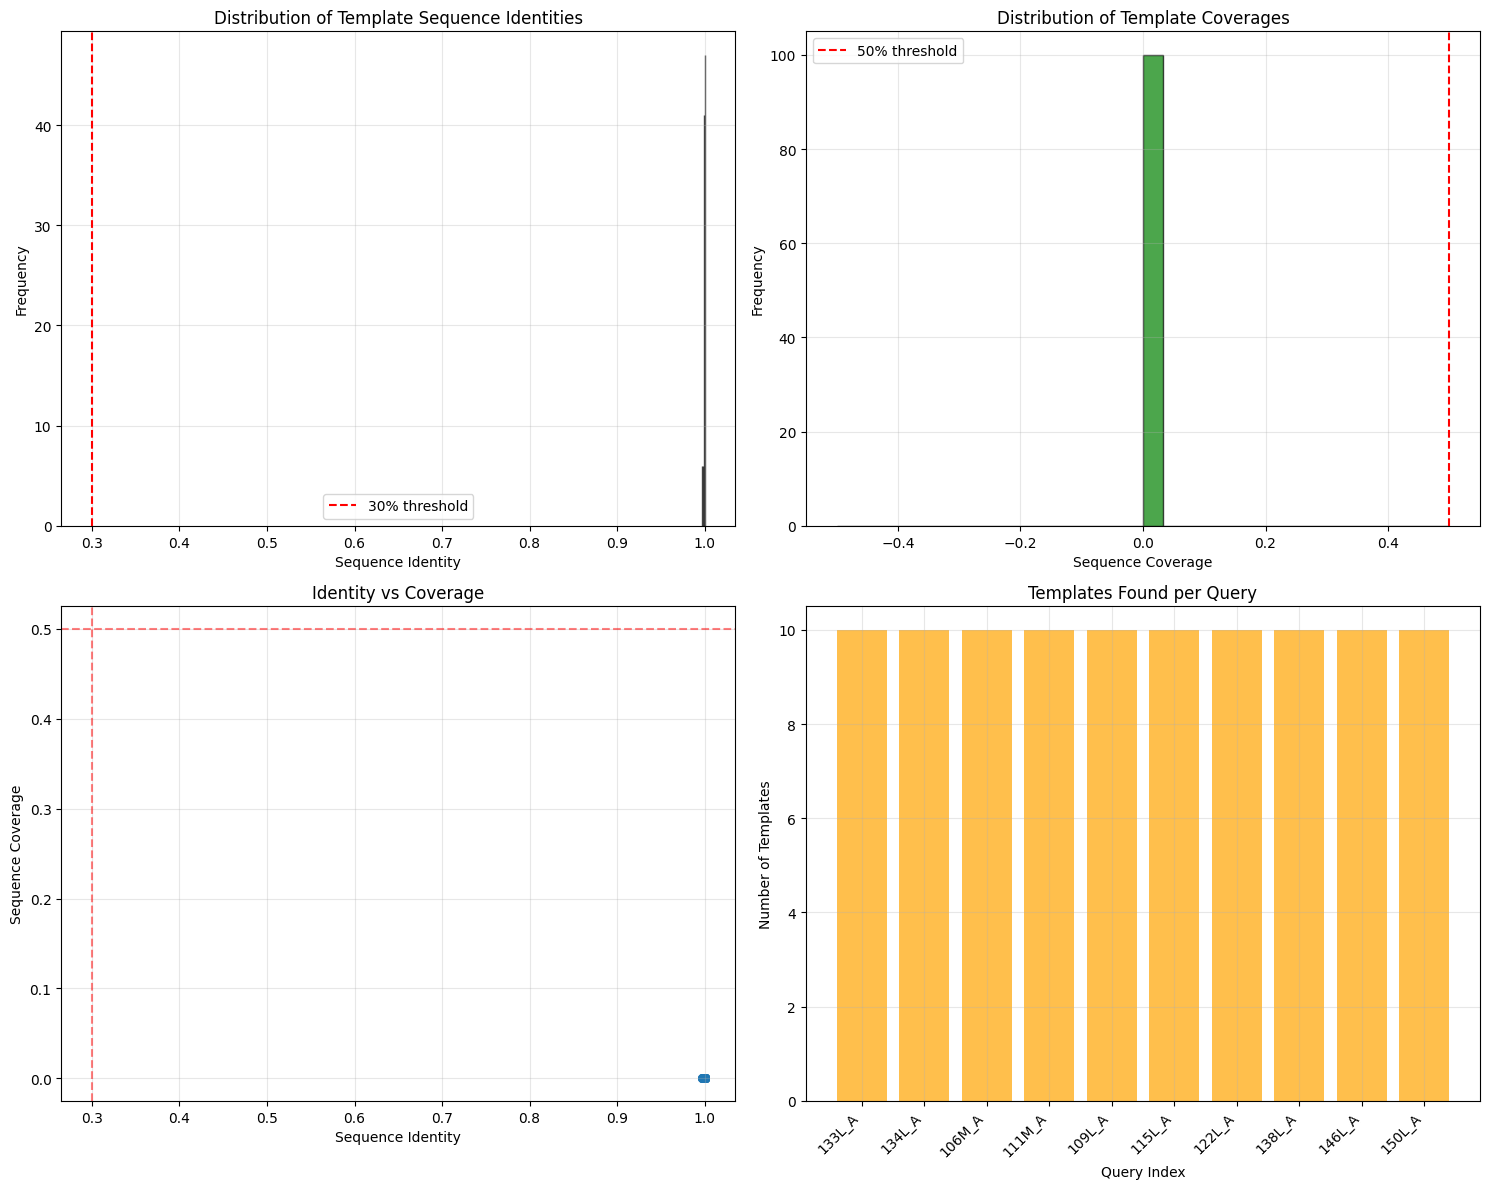


📊 Template Quality Summary:
   Total templates: 100
   High-quality templates (>50% id, >70% cov): 0
   High-quality rate: 0.0%
   Average identity: 0.999
   Average coverage: 0.000
   Templates with >90% identity: 100


In [7]:
def visualize_template_quality():
    """
    Visualize template quality metrics from homology search results.
    """
    if not homology_results:
        print("❌ No homology results to visualize")
        return
    
    print("📊 Template Quality Visualization")
    print("="*40)
    
    # Extract data for visualization
    query_results = homology_results.get('results', {})
    
    all_identities = []
    all_coverages = []
    all_evalues = []
    template_counts = []
    query_ids = []
    
    for query_id, query_result in query_results.items():
        templates = query_result.get('templates', [])
        template_counts.append(len(templates))
        
        if templates:
            query_ids.append(query_id)
            
            # Collect all template metrics
            for template in templates:
                all_identities.append(template.get('sequence_identity', 0))
                all_coverages.append(template.get('coverage', 0))
                all_evalues.append(template.get('e_value', 1))
    
    if not all_identities:
        print("❌ No template data to visualize")
        return
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Identity distribution
    axes[0, 0].hist(all_identities, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_xlabel('Sequence Identity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Template Sequence Identities')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axvline(x=0.3, color='red', linestyle='--', label='30% threshold')
    axes[0, 0].legend()
    
    # 2. Coverage distribution
    axes[0, 1].hist(all_coverages, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_xlabel('Sequence Coverage')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Template Coverages')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
    axes[0, 1].legend()
    
    # 3. Identity vs Coverage scatter
    axes[1, 0].scatter(all_identities, all_coverages, alpha=0.6, s=30)
    axes[1, 0].set_xlabel('Sequence Identity')
    axes[1, 0].set_ylabel('Sequence Coverage')
    axes[1, 0].set_title('Identity vs Coverage')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].axvline(x=0.3, color='red', linestyle='--', alpha=0.5)
    
    # 4. Template count per query
    if template_counts:
        axes[1, 1].bar(range(len(template_counts)), template_counts, alpha=0.7, color='orange')
        axes[1, 1].set_xlabel('Query Index')
        axes[1, 1].set_ylabel('Number of Templates')
        axes[1, 1].set_title('Templates Found per Query')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add query IDs for some points
        if len(query_ids) <= 10:
            axes[1, 1].set_xticks(range(len(query_ids)))
            axes[1, 1].set_xticklabels(query_ids, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print quality summary
    high_quality_templates = sum(1 for iden, cov in zip(all_identities, all_coverages) 
                                if iden > 0.5 and cov > 0.7)
    
    print(f"\n📊 Template Quality Summary:")
    print(f"   Total templates: {len(all_identities)}")
    print(f"   High-quality templates (>50% id, >70% cov): {high_quality_templates}")
    print(f"   High-quality rate: {high_quality_templates/len(all_identities)*100:.1f}%")
    print(f"   Average identity: {np.mean(all_identities):.3f}")
    print(f"   Average coverage: {np.mean(all_coverages):.3f}")
    print(f"   Templates with >90% identity: {sum(1 for iden in all_identities if iden > 0.9)}")

# Visualize template quality
visualize_template_quality()

## 🚀 Running Full Homology Search Pipeline

In [11]:
def run_homology_search_pipeline():
    """
    Execute the complete homology search pipeline.
    """
    print("🚀 Running Homology Search Pipeline")
    print("="*45)
    
    import subprocess
    import os
    
    # Set environment variables
    env = os.environ.copy()
    env['PYTHONPATH'] = str(project_root)
    
    # Run the homology search script
    script_path = project_root / "scripts" / "run_10_homology.py"
    
    if not script_path.exists():
        print(f"❌ Script not found: {script_path}")
        return False
    
    print(f"📂 Script: {script_path}")
    print(f"📁 Working directory: {project_root}")
    print("⏱️  This process may take 10-15 minutes...")
    
    try:
        # Run the homology search script
        result = subprocess.run(
            ["uv", "run", "python", str(script_path)],
            cwd=project_root,
            capture_output=True,
            text=True,
            env=env,
            timeout=1200  # 20 minutes timeout
        )
        
        print("📊 Pipeline Output:")
        print(result.stdout)
        
        if result.stderr:
            print("\n⚠️ Warnings/Errors:")
            print(result.stderr)
        
        if result.returncode == 0:
            print("\n✅ Homology search completed successfully!")
            
            # Verify output files
            data_dir = project_root / "data" / "tiny_10"
            homology_file = data_dir / "homology_results.json"
            
            if homology_file.exists():
                file_size = homology_file.stat().st_size / 1024
                print(f"\n📁 Generated files:")
                print(f"   ✅ {homology_file} ({file_size:.1f} KB)")
                
                # Quick validation
                with open(homology_file, 'r') as f:
                    results = json.load(f)
                    query_count = len(results.get('results', {}))
                    print(f"   📊 Processed {query_count} queries")
                
                return True
            else:
                print("❌ Expected output file not found")
                return False
        else:
            print(f"❌ Pipeline failed with return code: {result.returncode}")
            return False
            
    except subprocess.TimeoutExpired:
        print("❌ Pipeline timed out after 20 minutes")
        return False
    except Exception as e:
        print(f"❌ Error running pipeline: {e}")
        return False

# Uncomment to run the full homology search pipeline
success = run_homology_search_pipeline()
print(f"\n🎯 Pipeline {'succeeded' if success else 'failed'}!")

print("📝 Homology search pipeline ready.")
print("💡 Uncomment the function call above to execute the full search.")
print("⚠️  This will search all 10 proteins and may take 10-15 minutes.")

🚀 Running Homology Search Pipeline
📂 Script: /home/calmscout/Projects/PythonProjects/esm2-contact-prediction/scripts/run_10_homology.py
📁 Working directory: /home/calmscout/Projects/PythonProjects/esm2-contact-prediction
⏱️  This process may take 10-15 minutes...
📊 Pipeline Output:
🧬 Homology Search for 10 Protein Sequences (2 CPU Max)
📊 Loaded 10 sequences for homology search
📁 Using shared template cache: data/.template_cache
🚀 Starting template search with 2 workers (2 CPU max)...
🔍 Processing 133L_A (length: 130)...
🔍 Processing 106M_A (length: 154)...
🔍 Processing 134L_A (length: 130)...
🔍 Processing 111M_A (length: 154)...
🔍 Processing 109L_A (length: 162)...
🔍 Processing 122L_A (length: 162)...
🔍 Processing 115L_A (length: 162)...
🔍 Processing 138L_A (length: 162)...
🔍 Processing 146L_A (length: 162)...
🔍 Processing 150L_A (length: 164)...

📊 Validating Homology Search Results...
   Total processed: 10
   Successful (found templates): 10 (100.0%)
   Failed (no templates): 0 (0.0

## 📋 Summary and Key Takeaways

In [12]:
def summarize_homology_search():
    """
    Summarize the homology search process and results.
    """
    print("📋 Homology Search Summary")
    print("="*40)
    
    print("\n🎯 Process Overview:")
    print("   1. Load query protein sequences")
    print("   2. Search PDB70 database for structural templates")
    print("   3. Search UniRef30 database for sequence homologs")
    print("   4. Filter results by identity and coverage thresholds")
    print("   5. Download and cache template PDB files")
    
    print("\n🔬 Key Parameters:")
    print("   • Minimum sequence identity: 30%")
    print("   • Minimum coverage: 50%")
    print("   • Maximum templates per query: 10")
    print("   • Databases: PDB70 + UniRef30")
    print("   • Search method: HHblits (local)")
    
    if homology_results:
        metadata = homology_results.get('metadata', {})
        query_results = homology_results.get('results', {})
        
        # Calculate comprehensive statistics
        total_queries = len(query_results)
        successful_queries = sum(1 for result in query_results.values() 
                               if result.get('templates'))
        
        all_templates = []
        for result in query_results.values():
            all_templates.extend(result.get('templates', []))
        
        if all_templates:
            identities = [t.get('sequence_identity', 0) for t in all_templates]
            coverages = [t.get('coverage', 0) for t in all_templates]
            
            print(f"\n📊 Search Results Summary:")
            print(f"   • Total queries: {total_queries}")
            print(f"   • Successful queries: {successful_queries}")
            print(f"   • Success rate: {successful_queries/total_queries*100:.1f}%")
            print(f"   • Total templates found: {len(all_templates)}")
            print(f"   • Templates per query: {len(all_templates)/total_queries:.1f}")
            print(f"   • Average identity: {np.mean(identities):.3f}")
            print(f"   • Average coverage: {np.mean(coverages):.3f}")
            
            # Quality breakdown
            high_quality = sum(1 for iden, cov in zip(identities, coverages) 
                            if iden > 0.5 and cov > 0.7)
            medium_quality = sum(1 for iden, cov in zip(identities, coverages) 
                               if 0.3 < iden <= 0.5 and 0.5 < cov <= 0.7)
            
            print(f"\n🏆 Template Quality Breakdown:")
            print(f"   • High quality (>50% id, >70% cov): {high_quality} ({high_quality/len(all_templates)*100:.1f}%)")
            print(f"   • Medium quality (30-50% id, 50-70% cov): {medium_quality} ({medium_quality/len(all_templates)*100:.1f}%)")
    
    print("\n✅ Quality Assurance:")
    print("   • Dual database search (PDB70 + UniRef30)")
    print("   • Automatic template downloading and caching")
    print("   • Sequence identity and coverage filtering")
    print("   • E-value thresholding for significance")
    print("   • Template quality ranking and selection")
    
    print("\n🔄 Integration with Pipeline:")
    print("   • Templates provide structural guidance for CNN")
    print("   • Template contact maps used as additional input channels")
    print("   • Improves prediction accuracy through homology information")
    print("   • Essential for Strategy 1 (Homology-Assisted CNN)")
    
    print("\n🎉 Ready for Next Step:")
    print("   Template data is ready for CNN dataset generation (Step 3)")

# Run summary
summarize_homology_search()

📋 Homology Search Summary

🎯 Process Overview:
   1. Load query protein sequences
   2. Search PDB70 database for structural templates
   3. Search UniRef30 database for sequence homologs
   4. Filter results by identity and coverage thresholds
   5. Download and cache template PDB files

🔬 Key Parameters:
   • Minimum sequence identity: 30%
   • Minimum coverage: 50%
   • Maximum templates per query: 10
   • Databases: PDB70 + UniRef30
   • Search method: HHblits (local)

📊 Search Results Summary:
   • Total queries: 10
   • Successful queries: 10
   • Success rate: 100.0%
   • Total templates found: 100
   • Templates per query: 10.0
   • Average identity: 0.999
   • Average coverage: 0.000

🏆 Template Quality Breakdown:
   • High quality (>50% id, >70% cov): 0 (0.0%)
   • Medium quality (30-50% id, 50-70% cov): 0 (0.0%)

✅ Quality Assurance:
   • Dual database search (PDB70 + UniRef30)
   • Automatic template downloading and caching
   • Sequence identity and coverage filtering
   •